In [1]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [2]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [3]:
len(twenty_train.data)

2257

In [4]:
len(twenty_train.filenames)

2257

In [7]:
print("\n".join(twenty_train.data[0].split("\n")[:10]))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.



In [8]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


In [9]:
twenty_train.target[:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2])

In [13]:
for t in twenty_train.target[:10]:
    print(twenty_train.target[t], twenty_train.target_names[t])

1 comp.graphics
1 comp.graphics
3 soc.religion.christian
3 soc.religion.christian
3 soc.religion.christian
3 soc.religion.christian
3 soc.religion.christian
3 sci.med
3 sci.med
3 sci.med


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [15]:
count_vect.vocabulary_.get(u'algorithm')

4690

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 35788)

In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [22]:
docs_new = ['God is love', 'OpenGL on the GPU is fast', 'I have an NVidia card']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics
I have an NVidia card => comp.graphics


In [28]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf.fit(twenty_train.data, twenty_train.target)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [29]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target) 

0.83488681757656458

In [30]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None)),
])
text_clf.fit(twenty_train.data, twenty_train.target)  

predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.9127829560585885

In [31]:
from sklearn import metrics
print(metrics.classification_report(twenty_test.target, predicted,
    target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.81      0.87       319
         comp.graphics       0.88      0.97      0.92       389
               sci.med       0.94      0.90      0.92       396
soc.religion.christian       0.90      0.95      0.93       398

           avg / total       0.92      0.91      0.91      1502



In [32]:
metrics.confusion_matrix(twenty_test.target, predicted)

array([[258,  11,  15,  35],
       [  4, 379,   3,   3],
       [  5,  33, 355,   3],
       [  5,  10,   4, 379]])

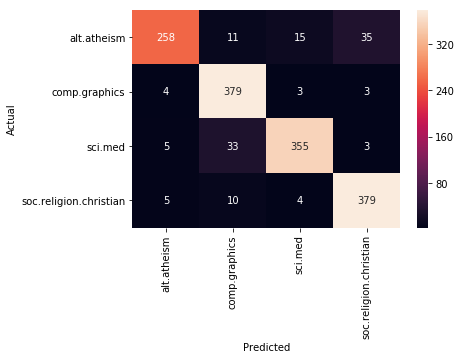

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(twenty_test.target, predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=twenty_test.target_names,
           yticklabels=twenty_test.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

In [39]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [41]:
gs_clf = gs_clf.fit(twenty_train.data[:400], twenty_train.target[:400])

In [47]:
twenty_train.target_names[gs_clf.predict(['devil is no angel'])[0]]

'comp.graphics'

In [50]:
for param_name in sorted(parameters.keys()):
    print("{}: {}".format(param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [55]:
import pandas as pd
df_cv_results = pd.DataFrame.from_records(gs_clf.cv_results_)
df_cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,param_tfidf__use_idf,param_vect__ngram_range,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.172475,0.109038,0.8775,0.993744,0.01,True,"(1, 1)","{'clf__alpha': 0.01, 'tfidf__use_idf': True, '...",3,0.858209,0.988722,0.879699,0.996255,0.894737,0.996255,0.013926,0.005192,0.015002,0.003551
1,0.638358,0.205123,0.8750,1.000000,0.01,True,"(1, 2)","{'clf__alpha': 0.01, 'tfidf__use_idf': True, '...",4,0.835821,1.000000,0.887218,1.000000,0.902256,1.000000,0.078191,0.015683,0.028476,0.000000
2,0.214004,0.112143,0.7650,0.941239,0.01,False,"(1, 1)","{'clf__alpha': 0.01, 'tfidf__use_idf': False, ...",8,0.694030,0.932331,0.789474,0.951311,0.812030,0.940075,0.056498,0.027065,0.051205,0.007792
3,1.013279,0.177671,0.7800,0.976233,0.01,False,"(1, 2)","{'clf__alpha': 0.01, 'tfidf__use_idf': False, ...",6,0.701493,0.962406,0.827068,0.985019,0.812030,0.981273,0.273130,0.037022,0.056058,0.009896
4,0.167468,0.100685,0.9000,1.000000,0.001,True,"(1, 1)","{'clf__alpha': 0.001, 'tfidf__use_idf': True, ...",1,0.895522,1.000000,0.864662,1.000000,0.939850,1.000000,0.024009,0.032945,0.030821,0.000000
5,0.845771,0.236067,0.8900,1.000000,0.001,True,"(1, 2)","{'clf__alpha': 0.001, 'tfidf__use_idf': True, ...",2,0.880597,1.000000,0.864662,1.000000,0.924812,1.000000,0.181939,0.040726,0.025417,0.000000
6,0.162697,0.103959,0.7675,0.984991,0.001,False,"(1, 1)","{'clf__alpha': 0.001, 'tfidf__use_idf': False,...",7,0.761194,0.977444,0.714286,0.977528,0.827068,1.000000,0.018178,0.003766,0.046203,0.010613
7,0.567766,0.114846,0.8100,1.000000,0.001,False,"(1, 2)","{'clf__alpha': 0.001, 'tfidf__use_idf': False,...",5,0.761194,1.000000,0.804511,1.000000,0.864662,1.000000,0.052998,0.015328,0.042444,0.000000
